<a href="https://colab.research.google.com/github/HarshaRani23/DIABETIC-PERIPHERALNEUROPATHY-DETECTION/blob/main/aiml_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
dataset_path="/content/drive/MyDrive/AIML_dataset/DFU/Patches"

In [ ]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

In [ ]:
# ### convert data to a normalized torch.FloatTensor
transforms = transforms.Compose([
    transforms.Resize((128, 32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
# choose the training and test datasets
# Loading datasets
data_dir ="/content/drive/MyDrive/AIML_dataset/DFU/Patches"
trainPercent, valPercent, testPercent = 0.7, 0.15, 0.15 # has to equal to 1
all_data = datasets.ImageFolder(data_dir, transform=transforms)

# obtain training indices that will be used for validation
num_data = len(all_data)
indices = list(range(num_data))
np.random.shuffle(indices)

# Finding the splitting points
split1, split2 = int(np.floor(trainPercent * num_data)), int(np.floor((trainPercent+valPercent) * num_data))
train_idx, valid_idx, test_idx = indices[:split1], indices[split1:split2], indices[split2:]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(all_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(all_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(all_data, batch_size=batch_size,
    sampler=test_sampler, num_workers=num_workers)

In [ ]:
# specify the image classes
label_map={'Abnormal(Ulcer)':'Ulcer','Normal(Healthy skin)':'Healthy'}
classes =list(label_map.values())

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img=img.cpu()
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [ ]:
import os
data_dir="/content/drive/MyDrive/AIML_dataset/DFU/Patches"
class_labels=os.listdir(data_dir)
print("class labels:",class_labels)

class labels: ['Abnormal(Ulcer)', 'Normal(Healthy skin)']


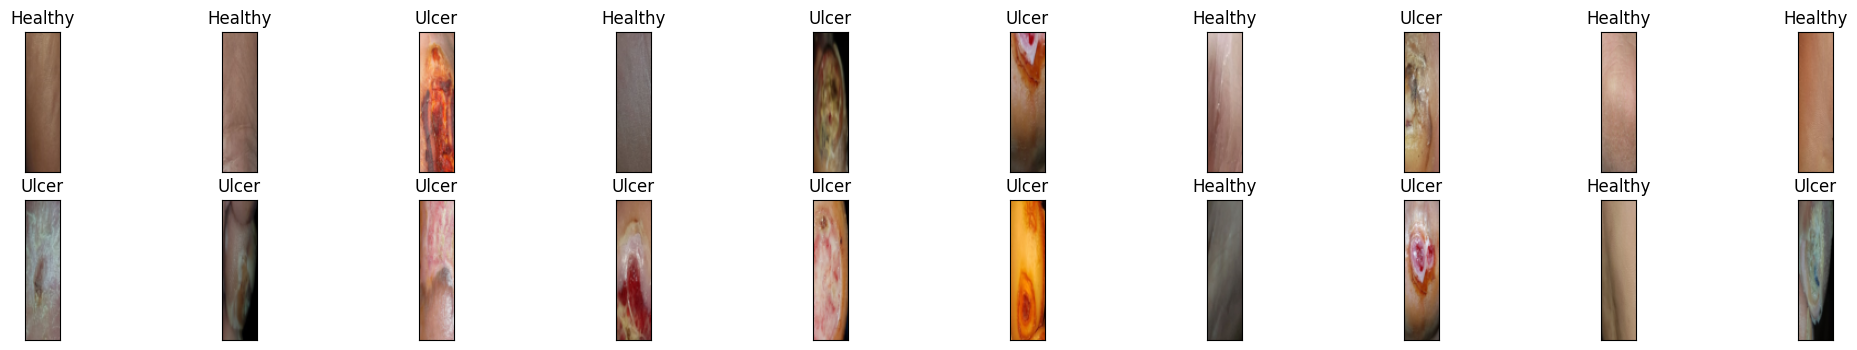

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    # Ensure label is within the range of classes
    label_index = labels[idx].item()

    # Get the actual class name or a fallback if index is out of range
    class_name = classes[label_index] if 0 <= label_index < len(classes) else f"Unknown (label: {label_index})"
    ax.set_title(class_name)

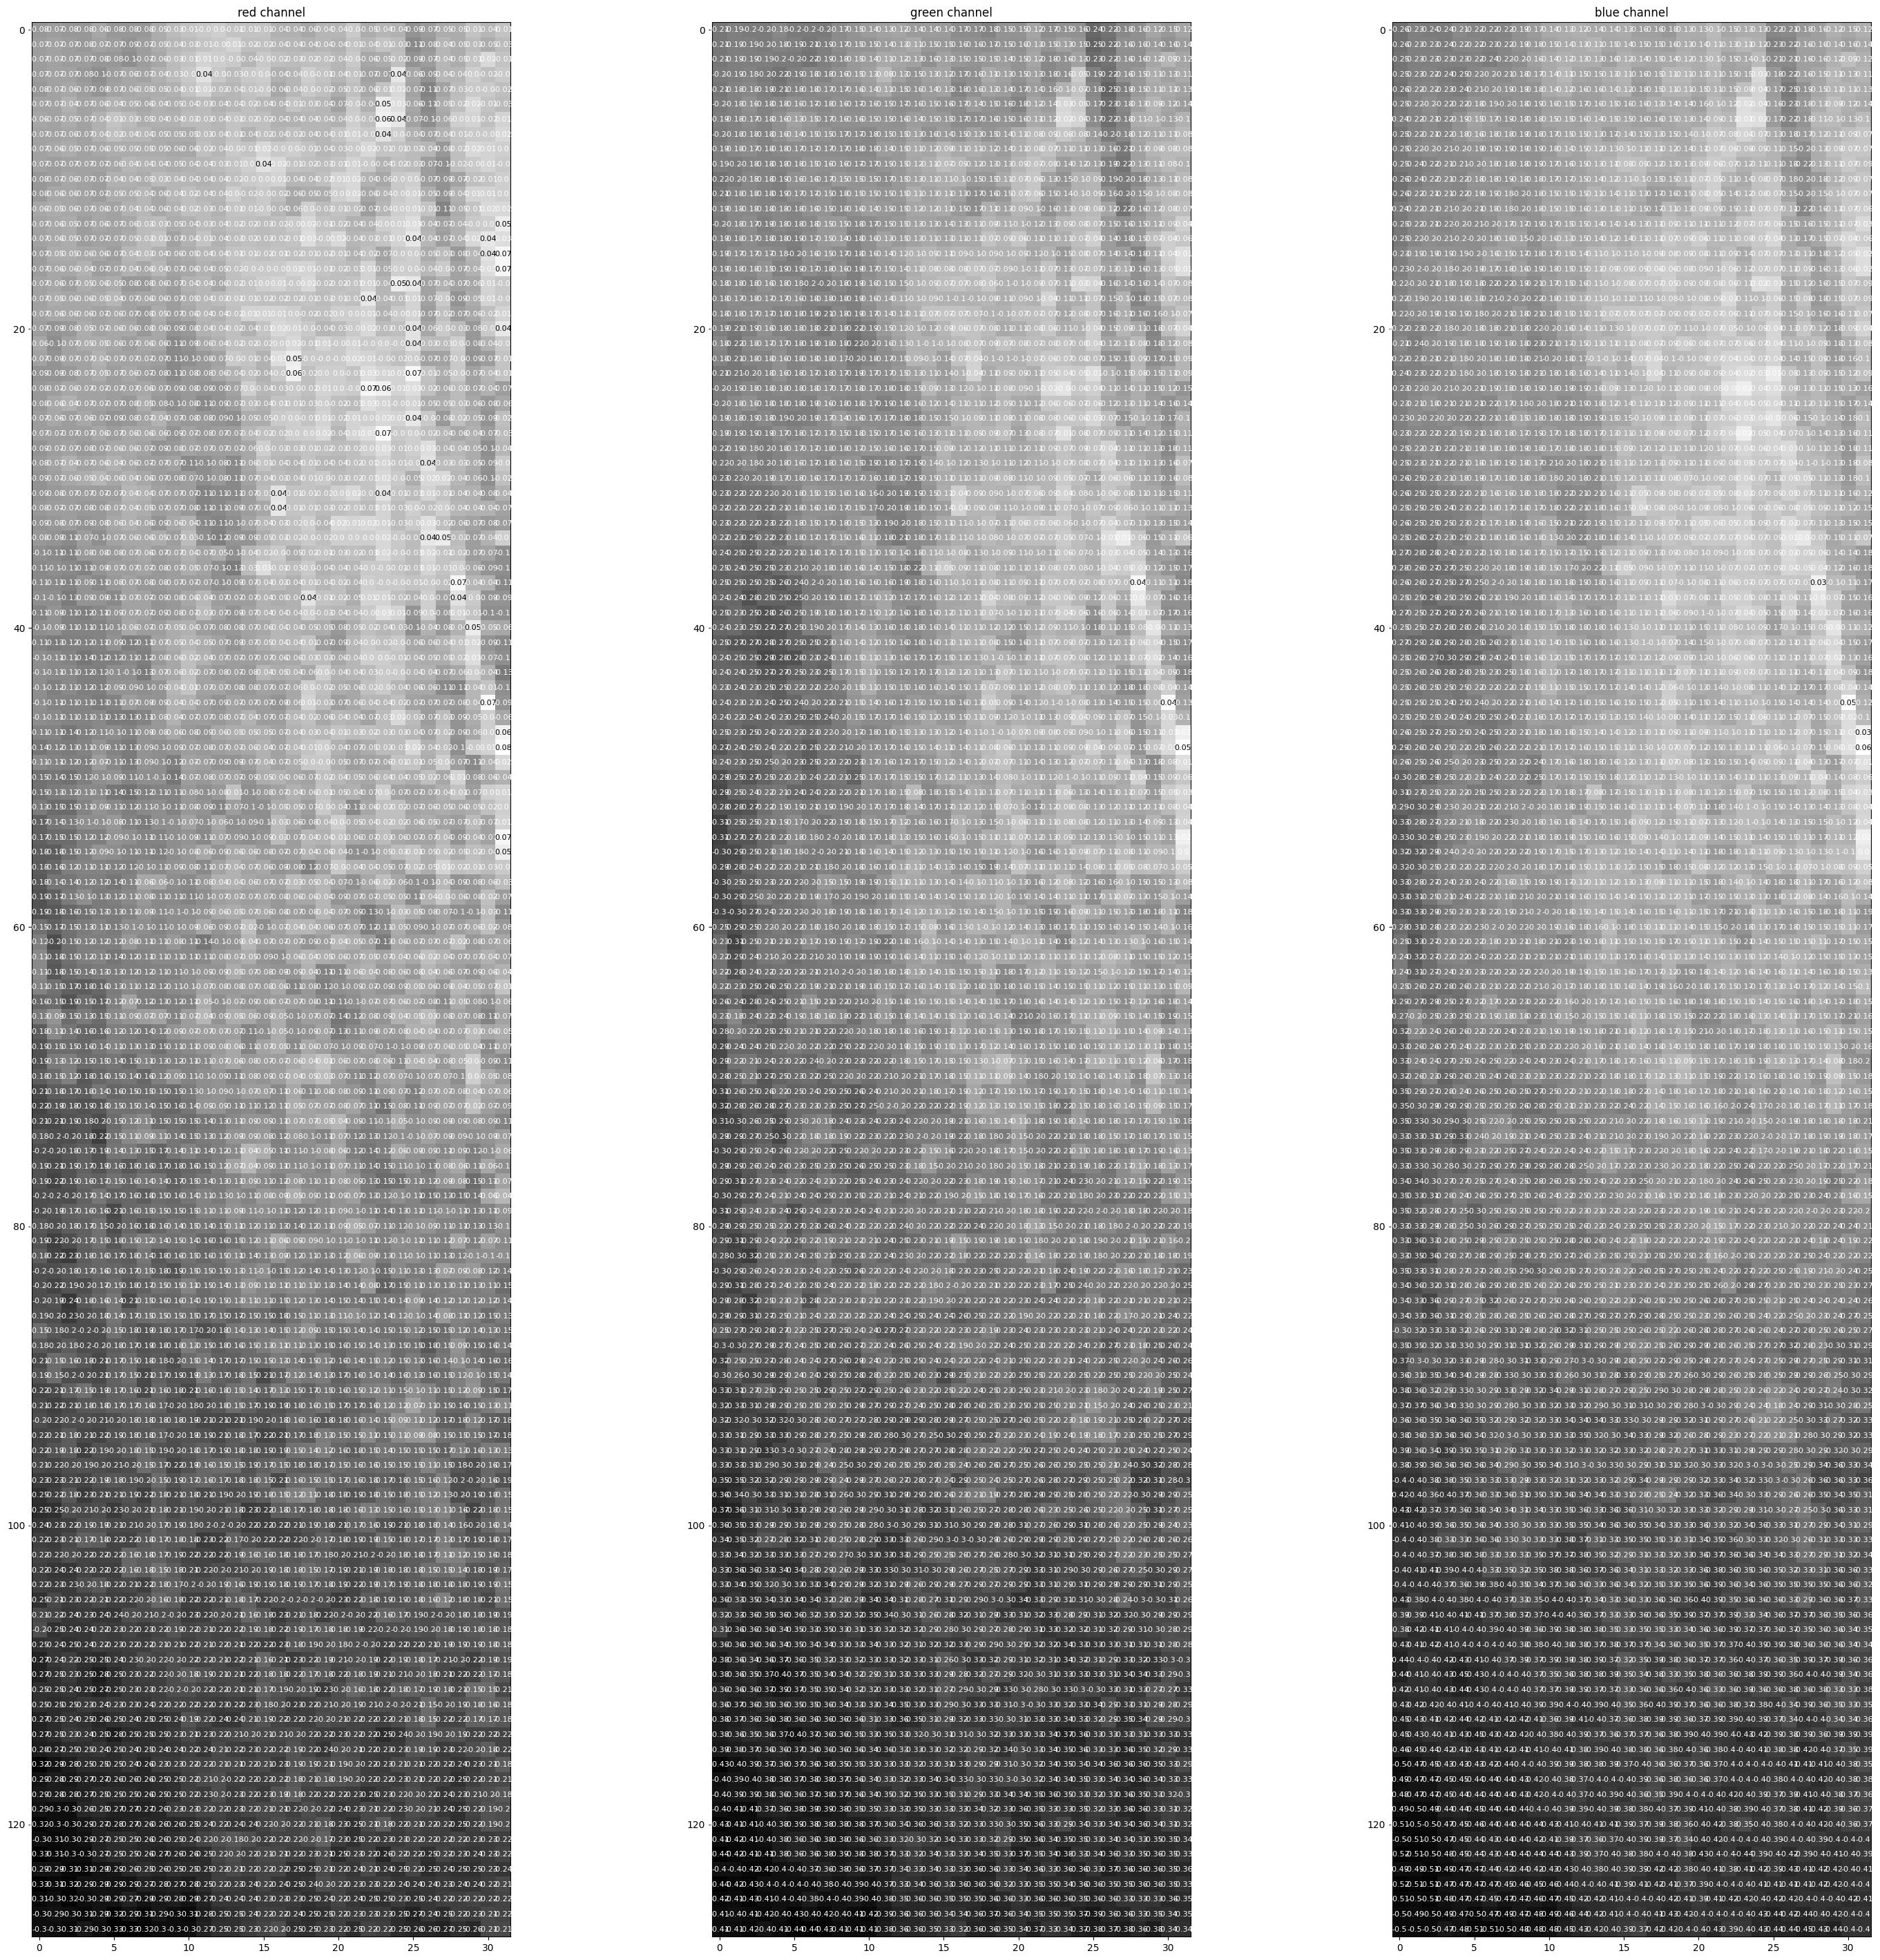

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 128x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 64x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 32x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 16x4x64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 8x2x128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        # output: 4*1*256


        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (4*1*256 -> 512)
        self.fc1 = nn.Linear(4*1*256, 512)
        # linear layer (512 -> 256)
        self.fc2 = nn.Linear(512, 256)
        # linear layer (256 -> 2)
        self.fc3 = nn.Linear(256, 2)
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        # flatten image input
        x = x.view(-1, 4*1*256)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 3nd hidden layer without relu
        x = self.fc3(x)

        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 100 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.484427 	Validation Loss: 0.103790
Validation loss decreased (inf --> 0.103790).  Saving model ...
Epoch: 2 	Training Loss: 0.484632 	Validation Loss: 0.103793
Epoch: 3 	Training Loss: 0.484696 	Validation Loss: 0.103795
Epoch: 4 	Training Loss: 0.484469 	Validation Loss: 0.103805
Epoch: 5 	Training Loss: 0.484287 	Validation Loss: 0.103815
Epoch: 6 	Training Loss: 0.484571 	Validation Loss: 0.103819
Epoch: 7 	Training Loss: 0.483983 	Validation Loss: 0.103822
Epoch: 8 	Training Loss: 0.484492 	Validation Loss: 0.103827
Epoch: 9 	Training Loss: 0.484608 	Validation Loss: 0.103831
Epoch: 10 	Training Loss: 0.484507 	Validation Loss: 0.103828
Epoch: 11 	Training Loss: 0.484263 	Validation Loss: 0.103825
Epoch: 12 	Training Loss: 0.484221 	Validation Loss: 0.103826
Epoch: 13 	Training Loss: 0.484459 	Validation Loss: 0.103821
Epoch: 14 	Training Loss: 0.484469 	Validation Loss: 0.103817
Epoch: 15 	Training Loss: 0.483739 	Validation Loss: 0.103813
Epoch: 16 	Trai

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

<ipython-input-18-30c1fa6c7551>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_cifar.pt'))


<All keys matched successfully>

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    # Check if correct is 0-dimensional
    if correct.ndim==0:
      correct=np.expand_dims(correct,axis=0)# Add dimension to correct
    for i in range(len(target)): # changed from batch_size to len(target) to avoid any issues
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.016127

Test Accuracy of Ulcer: 94% (73/77)
Test Accuracy of Healthy: 98% (81/82)

Test Accuracy (Overall): 96% (154/159)


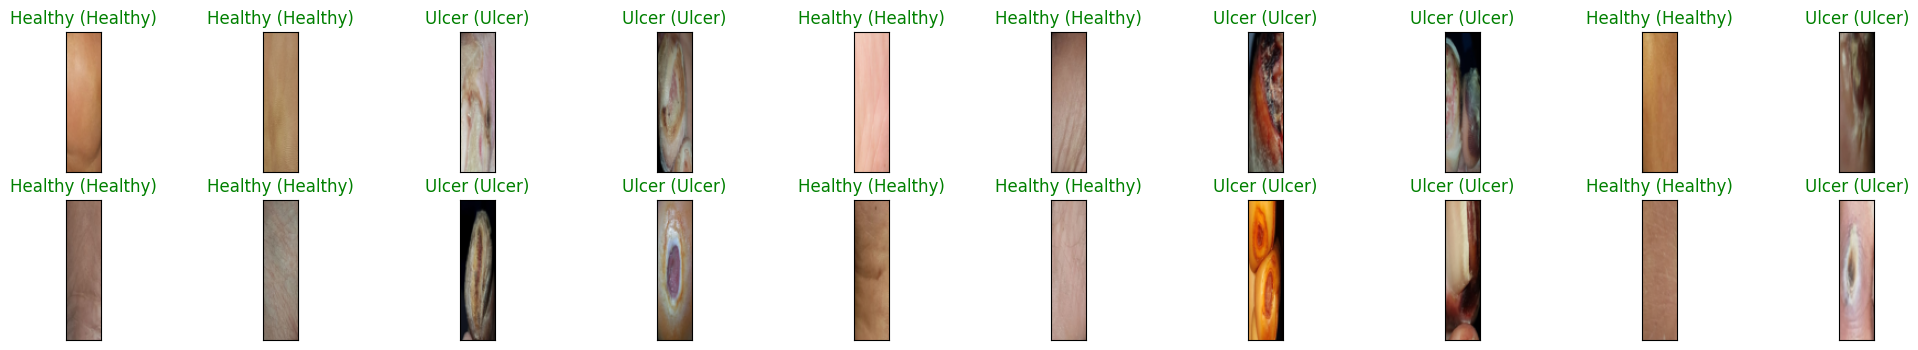

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

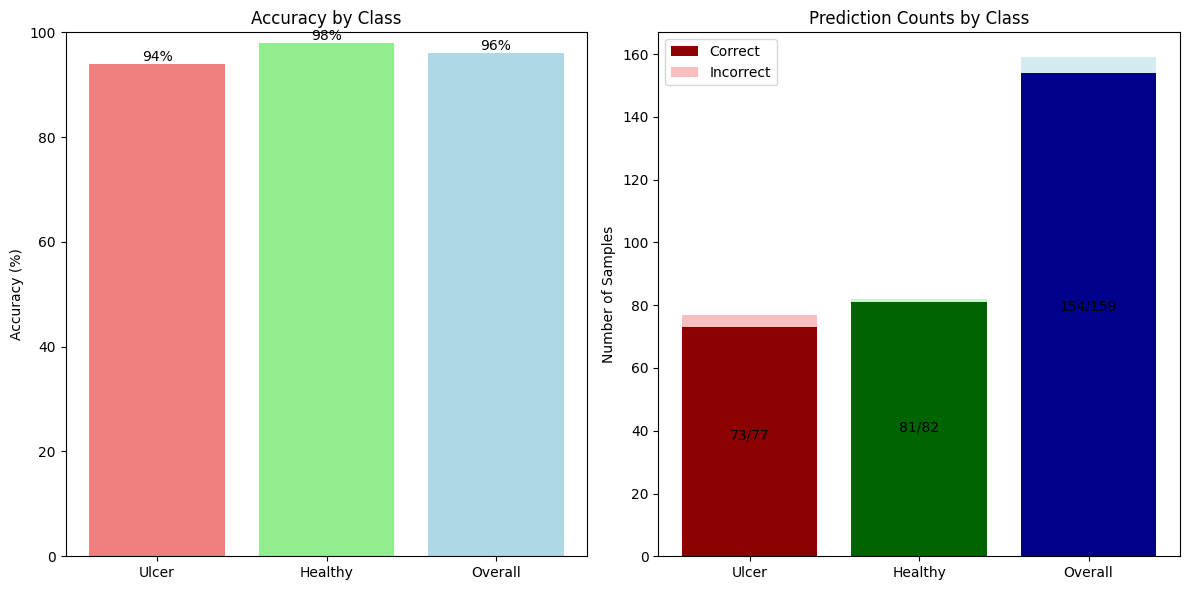

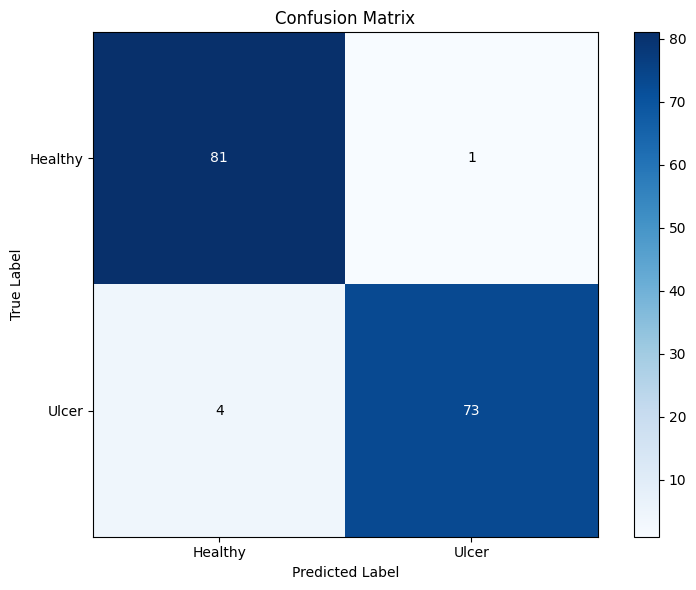

In [ ]:
# Import required libraries (if not already imported)
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the following metrics:
# Test Loss: 0.016127
# Test Accuracy of Ulcer: 94% (73/77)
# Test Accuracy of Healthy: 98% (81/82)
# Overall Accuracy: 96% (154/159)

# Create data for plotting
classes = ['Ulcer', 'Healthy', 'Overall']
accuracies = [94, 98, 96]  # Your accuracy values
counts = [(73,77), (81,82), (154,159)]  # Your correct/total counts

# Create bar plot for accuracies
plt.figure(figsize=(12, 6))

# Plot accuracy bars
plt.subplot(1, 2, 1)
bars = plt.bar(classes, accuracies, color=['lightcoral', 'lightgreen', 'lightblue'])
plt.title('Accuracy by Class')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis from 0 to 100%

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}%',
             ha='center', va='bottom')

# Plot prediction counts
plt.subplot(1, 2, 2)
correct_counts = [count[0] for count in counts]
total_counts = [count[1] for count in counts]
incorrect_counts = [total - correct for total, correct in zip(total_counts, correct_counts)]

# Create stacked bar chart
plt.bar(classes, correct_counts, label='Correct', color=['darkred', 'darkgreen', 'darkblue'])
plt.bar(classes, incorrect_counts, bottom=correct_counts, label='Incorrect',
        color=['lightcoral', 'lightgreen', 'lightblue'], alpha=0.5)

plt.title('Prediction Counts by Class')
plt.ylabel('Number of Samples')
plt.legend()

# Add count labels
for i in range(len(classes)):
    plt.text(i, total_counts[i]/2, f'{correct_counts[i]}/{total_counts[i]}',
             ha='center', va='center')

plt.tight_layout()
plt.show()

# Optional: Plot confusion matrix if you have it
# Assuming you have confusion matrix data
confusion_matrix = np.array([
    [81, 1],  # Healthy: 81 correct, 1 incorrect
    [4, 73]   # Ulcer: 73 correct, 4 incorrect
])

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Healthy', 'Ulcer']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Add text annotations
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()